In [35]:
import networkx as nx
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    precision_recall_curve,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin



In [36]:
# Σταθερό seed για αναπαραγωγιμότητα
np.random.seed(42)
random.seed(42)


In [37]:
# Διαβάζουμε τον γράφο από το csv αρχείο
G = nx.read_edgelist('netscience.csv', create_using=nx.Graph(), nodetype=int)

# G = nx.read_edgelist('elegans1.csv', delimiter=',', create_using=nx.Graph(), nodetype=int)



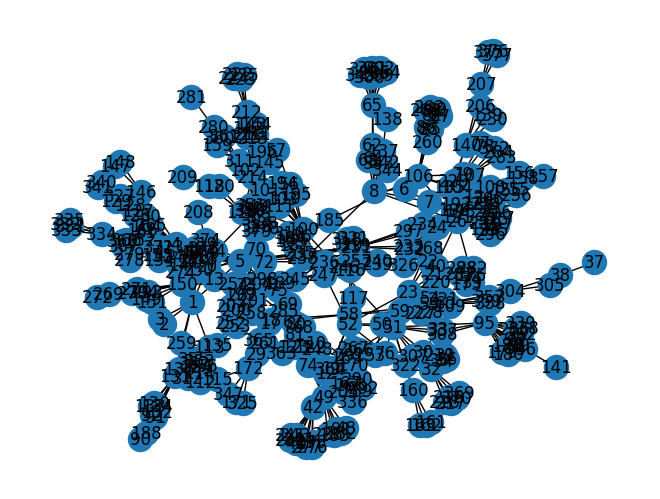

In [38]:
# # Σχεδίαση του γράφου

nx.draw(G, with_labels=True)
plt.show()


In [39]:
# Υπολογισμός στατιστικών του γράφου
def graph_stats(G):
    degrees = [degree for node, degree in G.degree()]
    node_count = len(G.nodes())
    edge_count = len(G.edges())
    degree_avg = np.mean(degrees) if degrees else 0
    density = 2 * edge_count / (node_count * (node_count - 1)) if node_count > 1 else 0
    return node_count, edge_count, degree_avg, degrees, density


# Εξαγωγή στατιστικών

initial_node_count, initial_edge_count, average_degree, degrees, density = graph_stats(G)
print("Number of nodes:", initial_node_count)
print("Number of edges:", initial_edge_count)
print("Graph density:", density)
print("Average degree:", average_degree)



Number of nodes: 379
Number of edges: 914
Graph density: 0.012759838617358406
Average degree: 4.823218997361478


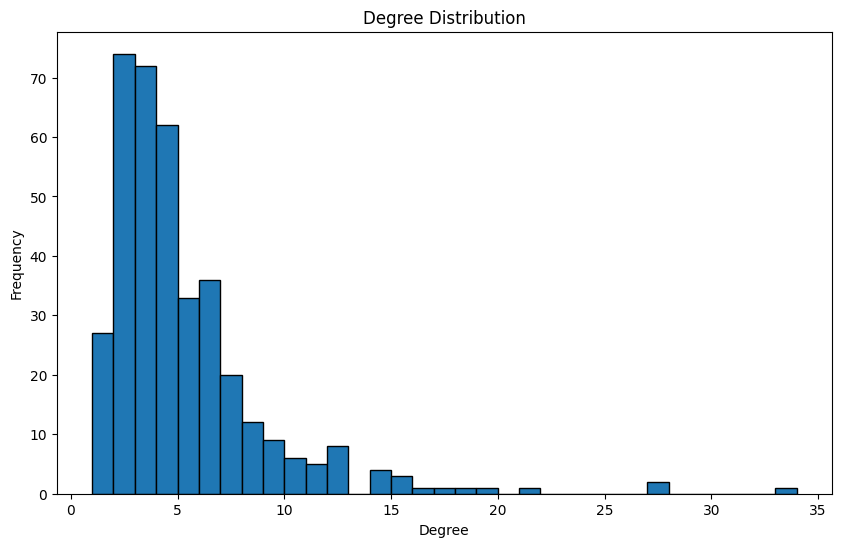

In [40]:
# Απεικόνιση κατανομής βαθμών

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1, 1), edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()



In [ ]:
# Συνάρτηση CCNPA 
def extract_CCNPA(G, edge, average_degree, alpha=0.5, beta=0.5):
    u, v = edge
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))
    common_neighbors = len(neighbors_u & neighbors_v)

    # Preferential Attachment
    preferential_attachment = len(neighbors_u) * len(neighbors_v)

    # Normalized Common Neighbors
    normalized_common_neighbors = common_neighbors / preferential_attachment if preferential_attachment != 0 else 0

    # Node degrees
    degree_u = G.degree[u]
    degree_v = G.degree[v]

    # Normalized Degree for both nodes
    normalized_degree_u = degree_u / average_degree
    normalized_degree_v = degree_v / average_degree
    average_normalized_degree = (normalized_degree_u + normalized_degree_v) / 2

    # Combined Metric
    combined_metric = alpha * normalized_common_neighbors + beta * average_normalized_degree

    return {
        "common_neighbors": common_neighbors,
        "preferential_attachment": preferential_attachment,
        "degree_u": degree_u,
        "degree_v": degree_v,
        "average_degree": average_degree,
        "normalized_common_neighbors": normalized_common_neighbors,
        "average_normalized_degree": average_normalized_degree,
        "combined_metric": combined_metric
    }
    

In [ ]:
# Συνάρτηση CKNCN
def extract_CKNCN(G, edge, density, alpha=0.5, beta=0.5):
    u, v = edge

    # Katz centrality
    katz = nx.katz_centrality(G, alpha=0.003)
    katz_similarity = katz[u] * katz[v]

    # Normalized Common Neighbors
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))
    common_neighbors = len(neighbors_u & neighbors_v)
    preferential_attachment = len(neighbors_u) * len(neighbors_v)
    ncn = common_neighbors / preferential_attachment if preferential_attachment != 0 else 0

    # Προσαρμογή βάσει πυκνότητας
    adjusted_katz = katz_similarity * (1 - density)
    adjusted_ncn = ncn * density

    # Συνδυασμός χαρακτηριστικών
    combined_score = alpha * adjusted_katz + beta * adjusted_ncn
    return combined_score


In [43]:
# Δημιουργία θετικών και αρνητικών δειγμάτων
positive_edges = list(G.edges())
negative_edges = random.sample(list(nx.non_edges(G)), len(positive_edges))

# Δεδομένα και ετικέτες
data = positive_edges + negative_edges
labels = [1] * len(positive_edges) + [0] * len(negative_edges)

# Διαχωρισμός σε σετ εκπαίδευσης και δοκιμής
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)



In [ ]:
# Grid Search για Beta και Alpha
alphas = np.linspace(0.1, 0.9, 9)
best_auc = 0
best_alpha = 0
best_beta = 0
results = []

for alpha in alphas:
    beta = 1 - alpha

    # Εξαγωγή χαρακτηριστικών
    X_train_features = [extract_CKNCN(G, edge, density, alpha, beta) for edge in X_train]
    X_test_features = [extract_CKNCN(G, edge, density, alpha, beta) for edge in X_test]
    
    # X_train_features = [extract_CCNPA(G, edge, average_degree, alpha, beta) for edge in X_train]
    # X_test_features = [extract_CCNPA(G, edge, average_degree, alpha, beta) for edge in X_test]

    # Δημιουργία DataFrames
    X_train_df = pd.DataFrame(X_train_features)
    X_test_df = pd.DataFrame(X_test_features)

    # # Εκπαίδευση Random Forest
    # model = RandomForestClassifier(random_state=42, class_weight='balanced')
    # model.fit(X_train_df, y_train)
    
    # Εκπαιδευση του Logistic Regression
    model = LogisticRegression(random_state=42, class_weight='balanced')
    model.fit(X_train_df, y_train)

    # Υπολογισμός AUC
    probabilities = model.predict_proba(X_test_df)[:, 1]
    auc = roc_auc_score(y_test, probabilities)
    results.append({'alpha': alpha, 'beta': beta, 'auc': auc})

    if auc > best_auc:
        best_auc = auc
        best_alpha = alpha
        best_beta = beta

print(f"Best Alpha: {best_alpha}, Best Beta: {best_beta}, Best AUC: {best_auc:.4f}")



In [24]:
# Τελικό μοντέλο με τις βέλτιστες παραμέτρους
X_train_features = [extract_CKNCN(G, edge, density, best_alpha, best_beta) for edge in X_train]
X_test_features = [extract_CKNCN(G, edge, density, best_alpha, best_beta) for edge in X_test]

# X_train_features = [extract_CCNPA(G, edge, average_degree, best_alpha, best_beta) for edge in X_train]
# X_test_features = [extract_CCNPA(G, edge, average_degree, best_alpha, best_beta) for edge in X_test]

X_train_df = pd.DataFrame(X_train_features)
X_test_df = pd.DataFrame(X_test_features)



In [25]:
# final_model = RandomForestClassifier(random_state=42, class_weight='balanced')
# final_model.fit(X_train_df, y_train)

In [26]:
# Εκπαίδευση του Logistic Regression Classifier
final_model = LogisticRegression(random_state=42, class_weight='balanced')
final_model.fit(X_train_df, y_train)



LogisticRegression(class_weight='balanced', random_state=42)

In [27]:
# Προβλέψεις και αξιολόγηση
final_probabilities = final_model.predict_proba(X_test_df)[:, 1]
roc_auc = roc_auc_score(y_test, final_probabilities)
print(f"Final AUC: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_test, final_probabilities)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
predicted_labels = (final_probabilities >= best_threshold).astype(int)

# Μετρικές αξιολόγησης
precision_score_val = precision_score(y_test, predicted_labels)
recall_score_val = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

# Εκτύπωση τελικών αποτελεσμάτων
print(f"Precision: {precision_score_val:.4f}")
print(f"Recall: {recall_score_val:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")



Final AUC: 0.7909
Precision: 0.8421
Recall: 0.7273
F1 Score: 0.7805
Best Threshold: 0.5001


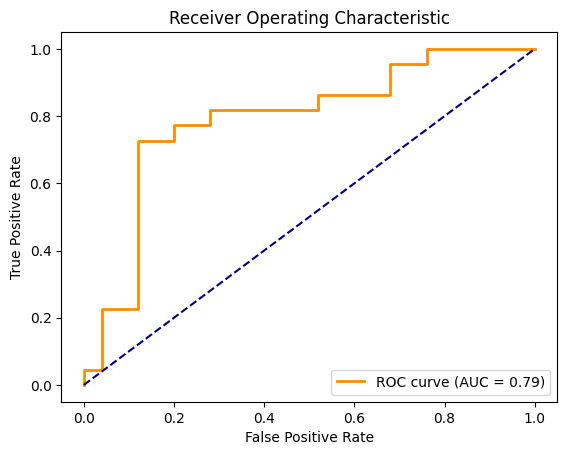

In [ ]:
# Απεικόνιση ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

